## Positional Encoding

I find it useful to keep track of the shape of my data as it goes on it's journey through the neural network

After the embedding, the shape is this vector sequence is

**(batch_size, sequence_length, embedding_dimensions)**

`[[-1.0845, -1.3986,  0.4033,  0.8380]`  give

` [ 1.5410, -0.2934, -2.1788,  0.5684 ]`  me

` [ 0.0098,  0.0430,  0.0206,  0.0090]]` covfefe
  
The next step is positional encoding. Imagine that the correct response to the above input 
is "heres your covfefe". This response makes sense given the input only in the order "give me covfefe". If I were to mix them up and say " me give covfefe", you might think that I was about to give you some covfefe, and that I was some sort of caveman. The other popular sequence models are the recurrent neural network (RNN) family of models, these models process the input vectors in chronological order, starting with "give", ending with "covfefe", updating a hidden state at each timestep. The RNN Decoder likewise continues to modify the hidden state as it predicts the output tokens. Transformers pay attention to all inputs at each output step but without the same timestep ordered hidden state that is different depending on the order of tokens, so unless we bake into the vectors some information about it's position in the sequence (first, second, 6th, last, etc), the Transformer will be dealing with essentially a bag of words. 

The paper [Attention is all you need](https://arxiv.org/abs/1706.03762) writes:

"Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks. The positional encodings have the same dimension `dmodel` as the embeddings, so that the two can be summed. There are many choices of positional encodings, learned and fixed. In this work, we use sine and cosine functions of different frequencies:
 
 $$\text{PE}(pos,2i)=sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$
 
 $$\text{PE}(pos,2i+1)=cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$
 
where pos is the position (timestep) and i is the dimension. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from 2π to 10000·2π. We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset k, $$PE_{pos+k}$$ can be represented as a linear function of $$PE_{pos}$$ 

We also experimented with using learned positional embeddings instead, and found that the two versions produced nearly identical results. We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training."

## Implementation

Notice that the sine and cosine functions apply to the dimensions alternatingly

Below is their Positional Encoder in PyTorch built to take in our shape **(batch_size, sequence_length, embedding_dimensions)** sequence of vectors

In [13]:
import math

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from matplotlib import pyplot as plt 

%matplotlib inline

In [14]:
class Embedder(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.embed = nn.Embedding(vocab_size, emb_dim)
    def forward(self, x):
        return self.embed(x)
    
class PositionalEncoder(nn.Module):

    def __init__(self, emb_dim, max_seq_len = 200, dropout = 0.1):
        super().__init__()
        self. emb_dim =  emb_dim
        self.dropout = nn.Dropout(dropout)
        # create constant 'pe' matrix with values dependant on pos and i
        # this matrix of shape (1, input_seq_len, emb_dim) is
        # cut down to shape (1, input_seq_len, emb_dim) in the forward pass
        # to be broadcasted across each sample in the batch 
        pe = torch.zeros(max_seq_len, emb_dim)
        for pos in range(max_seq_len):
            for i in range(0, emb_dim, 2):
                wavelength = 10000 ** ((2 * i)/ emb_dim)
                pe[pos, i] = math.sin(pos / wavelength)
                pe[pos, i + 1] = math.cos(pos / wavelength)
        pe = pe.unsqueeze(0) #add a batch dimention to your pe matrix 
        self.register_buffer('pe', pe) #block of data(persistent buffer)->temporary memory
 
    def forward(self, x):
        '''
        input: sequence of vectors  
               shape (batch size, input sequence length, vector dimentions)
        output: sequence of vectors of same shape as input with positional
                aka time encoding added to each sample 
                shape (batch size, input sequence length, vector dimentions)
        '''
        x = x * math.sqrt(self. emb_dim) # make embeddings relatively larger
        seq_len = x.size(1)
        pe = Variable(self.pe[:,:seq_len], requires_grad=False)
        if x.is_cuda:
            pe.cuda()
        x = x + pe #add constant to embedding
        return self.dropout(x)

Lets take for example the vector for "covfefe" and call it:

$$ e_{w} = [ 0.0098,  0.0430,  0.0206,  0.0090] $$

The version of our "covfefe" vector with the time encoding added to it looks like:

$$ e_{w}' =  e_{w} + PostionalEncoding = PostionallyEncodedVector$$

Since our vector has only 4 dimensions, we have positional encoder for 4 dimensions with only 2 iterations of i, this is i = 0 and i = 1, since for each value i, we get positional encoding for 2i and 2i+1.

2(0)=0, 2(0)+1 = 1, 2(1)=2, 2(1)+1=3

Accoring to the formula above, each of the 2i positions use sine and each of the 2i+1 use cosine, giving us the formula below for how to add a 4 dimensional positional encoding for any given postion *pos*

$$\begin{align*}e_{w}'&= e_{w} + \left[sin\left(\frac{pos}{10000^{2(0)/4}}\right), cos\left(\frac{pos}{10000^{2(0)/4}}\right),sin\left(\frac{pos}{10000^{2(1)/4}}\right),cos\left(\frac{pos}{10000^{2(1)/4}}\right)\right]\\
&= e_{w} + \left[sin\left(\frac{pos}{10000^{0}}\right), cos\left(\frac{pos}{10000^{0}}\right),sin\left(\frac{pos}{10000^{2/4}}\right),cos\left(\frac{pos}{10000^{2/4}}\right)\right]\\
&=e_{w} + \left[sin\left(pos\right), cos\left(pos\right),sin\left(\frac{pos}{100}\right),cos\left(\frac{pos}{100}\right)\right]\\
\end{align*}$$

for pos = 1, we get 

$$e_{w}=e_{w} + [0,1,0,1]$$

Look at the first row (first postion) of the positional encoding matrix `positioner.pe[:,:seq_len]` you should see a matching `[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00]`. Another way to look at this is that our encoding [0,1,0,1] is the first column of values in the graph below, the first vector in the sequence gets modified by the initila values of the sine and cosine, the future timesteps are modified by the values moving to the right in the graph.

In [17]:
torch.manual_seed(0)
    
embedding = Embedder(vocab_size=2, emb_dim=4)
source_sequence = torch.from_numpy(np.asarray([1,0,1])).unsqueeze(0)
print('source_sequence',source_sequence, source_sequence.shape)
print("---------------------------------------------------")
print("Embedding Matrix", embedding.embed.weight, embedding.embed.weight.shape)
print("---------------------------------------------------")
sequence_of_vectors = embedding(source_sequence)
print('sequence_of_vectors')
print(sequence_of_vectors, sequence_of_vectors.shape)
new_vector = torch.from_numpy(np.random.uniform(-0.1,0.1,(1, 4)).astype(np.float32))
print('new_vector', new_vector, new_vector.shape)
print("---------------------------------------------------")
concatenated_matrix = torch.cat((embedding.embed.weight, new_vector),dim=0)
embedding.embed.weight=nn.Parameter(concatenated_matrix,requires_grad=True)
print("New Embedding Matrix", embedding.embed.weight, embedding.embed.weight.shape)
print("---------------------------------------------------")
source_sequence = torch.from_numpy(np.asarray([1,0,2])).unsqueeze(0)
print('source_sequence',source_sequence, source_sequence.shape)
print("---------------------------------------------------")
sequence_of_vectors = embedding(source_sequence)
print('sequence_of_vectors')
print(sequence_of_vectors, sequence_of_vectors.shape)

source_sequence tensor([[1, 0, 1]]) torch.Size([1, 3])
---------------------------------------------------
Embedding Matrix Parameter containing:
tensor([[ 1.5410, -0.2934, -2.1788,  0.5684],
        [-1.0845, -1.3986,  0.4033,  0.8380]], requires_grad=True) torch.Size([2, 4])
---------------------------------------------------
sequence_of_vectors
tensor([[[-1.0845, -1.3986,  0.4033,  0.8380],
         [ 1.5410, -0.2934, -2.1788,  0.5684],
         [-1.0845, -1.3986,  0.4033,  0.8380]]], grad_fn=<EmbeddingBackward0>) torch.Size([1, 3, 4])
new_vector tensor([[-0.0312, -0.0786,  0.0914,  0.0631]]) torch.Size([1, 4])
---------------------------------------------------
New Embedding Matrix Parameter containing:
tensor([[ 1.5410, -0.2934, -2.1788,  0.5684],
        [-1.0845, -1.3986,  0.4033,  0.8380],
        [-0.0312, -0.0786,  0.0914,  0.0631]], requires_grad=True) torch.Size([3, 4])
---------------------------------------------------
source_sequence tensor([[1, 0, 2]]) torch.Size([1, 3]

In [19]:
seq_len = sequence_of_vectors.size(1)
positioner = PositionalEncoder(emb_dim=4, max_seq_len=100, dropout=0.0) 
print(positioner.pe.shape)
print('seq_len',seq_len)
print(positioner.pe[:,:seq_len])
print('sequence_of_vectors')
print(sequence_of_vectors, sequence_of_vectors.shape) 
print("---------------------------------------------------")
sequence_of_vectors = positioner(sequence_of_vectors)
print(sequence_of_vectors, sequence_of_vectors.shape)

torch.Size([1, 100, 4])
seq_len 3
tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  1.0000e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  2.0000e-04,  1.0000e+00]]])
sequence_of_vectors
tensor([[[-2.1690, -1.7972,  0.8067,  2.6761],
         [ 3.9235, -0.0466, -4.3575,  2.1369],
         [ 0.8468, -0.5734,  0.1830,  1.1262]]], grad_fn=<AddBackward0>) torch.Size([1, 3, 4])
---------------------------------------------------
tensor([[[-4.3381, -2.5944,  1.6134,  6.3521],
         [ 8.6884,  0.4472, -8.7149,  5.2737],
         [ 2.6030, -1.5629,  0.3663,  3.2523]]], grad_fn=<AddBackward0>) torch.Size([1, 3, 4])


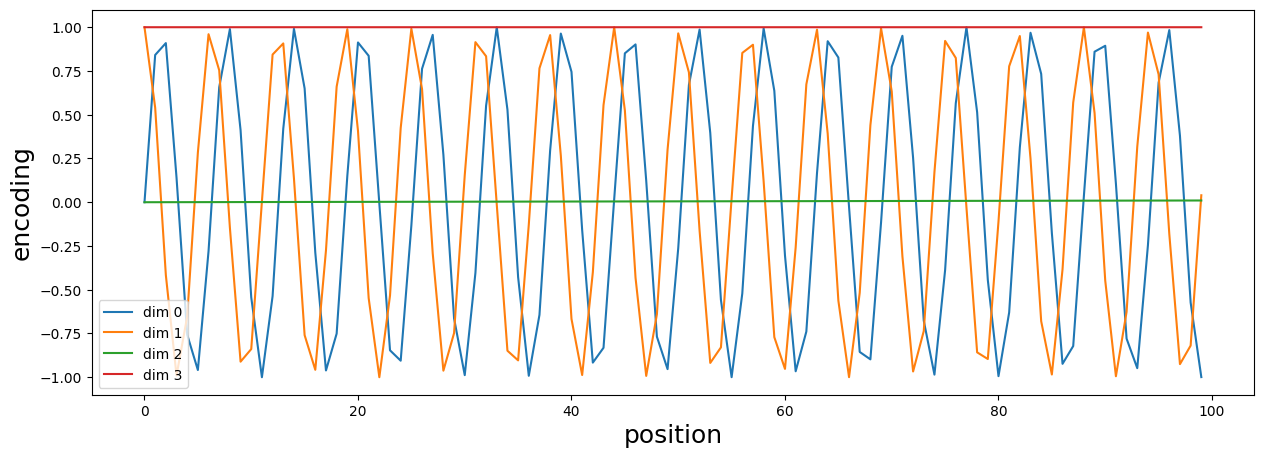

In [16]:

plt.figure(figsize=(15, 5)) 
y = positioner(Variable(torch.zeros(1, 100, 4))) 
plt.plot(np.arange(100), y[0, :, :].data.numpy())
plt.xlabel('position', fontsize=18)
plt.ylabel('encoding', fontsize=18)
plt.legend(["dim %d"%p for p in [0,1,2,3]])

When studying Transformers, the part I found most confusing was Positional Encoding. Why it works. The reason is elaborated in
[this Blog by  Lennart Van der Goten](http://vandergoten.ai/2018-09-18-attention-is-all-you-need/)

Below is a modified diagram from that blog that shows how each positon gets a unique encoding added to it. Above we use an abnormally small 4 dimensions, below you see the range of encodings than are added to a arbitrarily longer choice of dimensions for d_model, aka emb_dim. The alternating sine cosine and slowly elongating wavelength with later dimensions ensures no positional encoding is encoded the same as timestep.

<img src="../saved/images/positionalencoding.png">

Now lets add the positional encoding to our sequence